Number of Patients Readmitted: 15
Average Staff Satisfaction: 3.50
Average Cleanliness Satisfaction: 3.60
Average Food Satisfaction: 3.53
Average Comfort Satisfaction: 3.73
Average Communication Satisfaction: 3.70

Logistic Regression Results:
----------------------------
              precision    recall  f1-score   support

           0       0.59      0.67      0.62        15
           1       0.62      0.53      0.57        15

    accuracy                           0.60        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.60      0.60      0.60        30



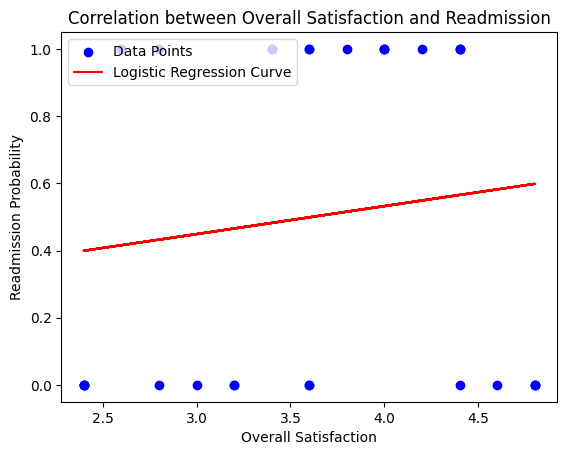

In [ ]:
import sqlite3
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pathlib
conn = sqlite3.connect("hospital_data.db")
cursor = conn.cursor()
cursor.execute("""
CREATE TABLE IF NOT EXISTS patients (
    PatientID INTEGER PRIMARY KEY,
    Readmission INTEGER,
    StaffSatisfaction INTEGER,
    CleanlinessSatisfaction INTEGER,
    FoodSatisfaction INTEGER,
    ComfortSatisfaction INTEGER,
    CommunicationSatisfaction INTEGER
)
""")
conn.commit()
file_path = pathlib.Path("/Users/cjara/Downloads/Week14Assignment.txt")
with open(file_path, "r") as file:
    lines = file.readlines()
    header = lines[0].strip().split(",")
    for line in lines[1:]:
        data = line.strip().split(",")
        cursor.execute("""
        INSERT INTO patients (PatientID, Readmission, StaffSatisfaction, 
                              CleanlinessSatisfaction, FoodSatisfaction, 
                              ComfortSatisfaction, CommunicationSatisfaction)
        VALUES (?, ?, ?, ?, ?, ?, ?)
        """, data)
conn.commit()
cursor.execute("SELECT COUNT(*) FROM patients WHERE Readmission = 1")
readmitted_count = cursor.fetchone()[0]
print(f"Number of Patients Readmitted: {readmitted_count}")
categories = ['StaffSatisfaction', 'CleanlinessSatisfaction', 'FoodSatisfaction', 
              'ComfortSatisfaction', 'CommunicationSatisfaction']
averages = {}
for category in categories:
    cursor.execute(f"SELECT AVG({category}) FROM patients")
    averages[category] = cursor.fetchone()[0]
for category, avg in averages.items():
    print(f"Average {category.replace('Satisfaction', '')} Satisfaction: {avg:.2f}")
query = """
SELECT Readmission, 
       (StaffSatisfaction + CleanlinessSatisfaction + FoodSatisfaction + 
        ComfortSatisfaction + CommunicationSatisfaction) / 5.0 AS OverallSatisfaction
FROM patients
"""
df = pd.read_sql_query(query, conn)
X = df[['OverallSatisfaction']].values
y = df['Readmission'].values
model = LogisticRegression()
model.fit(X, y)
probabilities = model.predict_proba(X)[:, 1]
y_pred = model.predict(X)
print("\nLogistic Regression Results:\n----------------------------")
print(classification_report(y, y_pred))
plt.scatter(df['OverallSatisfaction'], df['Readmission'], c='blue', label='Data Points')
plt.plot(df['OverallSatisfaction'], probabilities, color='red', label='Logistic Regression Curve')
plt.xlabel('Overall Satisfaction')
plt.ylabel('Readmission Probability')
plt.legend()
plt.title('Correlation between Overall Satisfaction and Readmission')
plt.show()
conn.close()
